<a href="https://colab.research.google.com/github/shayshankr/Reinforcement-Learning-for-Personalized-Diabetes-Care/blob/main/code_sr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Prepration

In [1]:
import zipfile
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler




# Path to your zip archive (update this)
zip_path = '/content/diabetes-data.zip'




# Codes for insulin and glucose measurements as strings (to match data)
insulin_codes = {'33', '34', '35'}
glucose_codes = {'48', '57', '58', '59', '60', '61', '62', '63', '64'}


# Converting time

def convert_time(row):
    try:
        # Try parsing date and time string normally
        return pd.to_datetime(row['date'] + ' ' + row['time'])
    except:
        # Handle special logical time labels (e.g., breakfast, lunch) by mapping them to fixed times
        logical_times = {'breakfast': '08:00', 'lunch': '12:00', 'dinner': '18:00', 'bedtime': '22:00'}
        time_str = row['time'].lower()
        if time_str in logical_times:
            # Convert date + mapped logical time to datetime
            return pd.to_datetime(row['date'] + ' ' + logical_times[time_str])
        else:
            # If time format unknown, return NaT (Not a Time)
            return pd.NaT


# Reading and combining file from zip

# Open zip file and extract all patient data files
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # Filter only files with patient data path pattern
    patient_files = [f for f in zip_ref.namelist() if 'Diabetes-Data/data-' in f]
    all_dfs = []
    for file in patient_files:
        # Read each patient file as a dataframe with specified columns
        with zip_ref.open(file) as f:
            df = pd.read_csv(f, sep='\t', header=None, names=['date', 'time', 'code', 'value'], dtype=str)
            # Add patient_id column using filename to track patient origin
            df['patient_id'] = file
            all_dfs.append(df)

# Combine all patient dataframes into one large dataframe
raw_df = pd.concat(all_dfs, ignore_index=True)



# Keep only rows with insulin or glucose measurement codes
filtered_df = raw_df[raw_df['code'].isin(insulin_codes.union(glucose_codes))].copy()

# Apply function to convert date and time columns into single datetime column
filtered_df['datetime'] = filtered_df.apply(convert_time, axis=1)

# Remove rows where datetime conversion failed (NaT)
filtered_df.dropna(subset=['datetime'], inplace=True)

# Convert the 'value' column to numeric; convert invalid parsing to NaN
filtered_df['value'] = pd.to_numeric(filtered_df['value'], errors='coerce')

# Drop rows where 'value' could not be converted to numeric
filtered_df.dropna(subset=['value'], inplace=True)

# Create a new column to label feature as 'insulin' or 'glucose' based on code
filtered_df['feature_type'] = filtered_df['code'].apply(
    lambda c: 'insulin' if c in insulin_codes else 'glucose')

# Reshape data to wide format: each row is patient_id + datetime with insulin and glucose columns
pivot_df = filtered_df.pivot_table(
    index=['patient_id', 'datetime'], columns='feature_type', values='value', aggfunc='sum').reset_index()

# Fill missing insulin values with 0, assuming no dose given
pivot_df['insulin'] = pivot_df['insulin'].fillna(0)

# Fill missing glucose values by carrying forward last valid measurement
pivot_df['glucose'] = pivot_df['glucose'].ffill()

# If glucose still missing (e.g., at start), fill with median glucose value of dataset
glucose_median = pivot_df['glucose'].median() # Calculate median once
pivot_df['glucose'] = pivot_df['glucose'].ffill().fillna(glucose_median)


# Explicitly convert insulin and glucose columns to float type
pivot_df['insulin'] = pivot_df['insulin'].astype(float)
pivot_df['glucose'] = pivot_df['glucose'].astype(float)

# Normalize insulin and glucose features using StandardScaler (mean=0, std=1)
scaler = StandardScaler()
pivot_df[['insulin_norm', 'glucose_norm']] = scaler.fit_transform(pivot_df[['insulin', 'glucose']])

# Sort data by patient_id and datetime for ordered analysis
pivot_df.sort_values(['patient_id', 'datetime'], inplace=True)
pivot_df.reset_index(drop=True, inplace=True)

# Output preview of the final prepared dataframe
print(pivot_df.head())


feature_type                           patient_id            datetime  \
0             diabetes-data/Diabetes-Data/data-01 1991-04-21 09:09:00   
1             diabetes-data/Diabetes-Data/data-01 1991-04-21 17:08:00   
2             diabetes-data/Diabetes-Data/data-01 1991-04-21 22:51:00   
3             diabetes-data/Diabetes-Data/data-01 1991-04-22 07:35:00   
4             diabetes-data/Diabetes-Data/data-01 1991-04-22 13:40:00   

feature_type  glucose  insulin  insulin_norm  glucose_norm  
0               100.0     22.0      1.151959     -0.763804  
1               119.0      7.0     -0.073814     -0.533646  
2               123.0      0.0     -0.645842     -0.485191  
3               216.0     23.0      1.233678      0.641375  
4               216.0      2.0     -0.482406      0.641375  


In [2]:
pivot_df

feature_type,patient_id,datetime,glucose,insulin,insulin_norm,glucose_norm
0,diabetes-data/Diabetes-Data/data-01,1991-04-21 09:09:00,100.0,22.0,1.151959,-0.763804
1,diabetes-data/Diabetes-Data/data-01,1991-04-21 17:08:00,119.0,7.0,-0.073814,-0.533646
2,diabetes-data/Diabetes-Data/data-01,1991-04-21 22:51:00,123.0,0.0,-0.645842,-0.485191
3,diabetes-data/Diabetes-Data/data-01,1991-04-22 07:35:00,216.0,23.0,1.233678,0.641375
4,diabetes-data/Diabetes-Data/data-01,1991-04-22 13:40:00,216.0,2.0,-0.482406,0.641375
...,...,...,...,...,...,...
17494,diabetes-data/Diabetes-Data/data-70,1989-05-08 22:00:00,145.0,0.0,-0.645842,-0.218692
17495,diabetes-data/Diabetes-Data/data-70,1989-05-09 08:00:00,259.0,8.0,0.007904,1.162261
17496,diabetes-data/Diabetes-Data/data-70,1989-05-10 08:00:00,259.0,7.0,-0.073814,1.162261
17497,diabetes-data/Diabetes-Data/data-70,1989-05-11 08:00:00,259.0,7.0,-0.073814,1.162261


## Environment Creation

In [ ]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np

class DiabetesEnv(gym.Env):
    metadata = {'render_modes': ['human']}  # Supported render modes

    def __init__(self, data):
        super().__init__()
        self.data = data
        # Extract unique patient IDs from the data
        self.patients = data['patient_id'].unique()

        # Features used: normalized insulin (related to action), normalized glucose (state)
        self.features = ['insulin_norm', 'glucose_norm']

        # Define discrete action space: 3 possible insulin dose adjustments
        # 0 = no adjustment, 1 = moderate dose, 2 = high dose
        self.action_space = spaces.Discrete(3)

        # Observation space includes normalized insulin and glucose as continuous values
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(2,), dtype=np.float32)

        # Initialize indices and patient data placeholders
        self.current_patient_idx = None
        self.current_time_idx = None
        self.current_patient_data = None
        self.render_mode = None  # Render mode (e.g., 'human')

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        # Randomly select a patient index to start
        self.current_patient_idx = np.random.randint(len(self.patients))
        patient_id = self.patients[self.current_patient_idx]

        # Extract data for the selected patient and reset index
        self.current_patient_data = self.data[self.data['patient_id'] == patient_id].reset_index(drop=True)
        self.current_time_idx = 0  # Start at the first time step

        # Return initial state and empty info dict as per gym API
        return self._get_state(), {}

    def _get_state(self):
        # Get feature values for the current timestep as float32 numpy array
        row = self.current_patient_data.iloc[self.current_time_idx]
        return row[self.features].values.astype(np.float32)

    def step(self, action):
        # Get current state
        current_state = self._get_state()
        done = False

        # Check if this is the last time step for the current patient
        if self.current_time_idx + 1 >= len(self.current_patient_data):
            done = True
            # If done, next state is zero vector (episode end)
            next_state = np.zeros_like(current_state)
            reward = 0.0
            reward_health = 0.0
            side_effect = 0.0
            cost = 0.0
        else:
            # Get next state features from next timestep
            next_state = self.current_patient_data.iloc[self.current_time_idx + 1][self.features].values.astype(np.float32)

            # Calculate health reward: positive if glucose decreases (improvement)
            reward_health = current_state[1] - next_state[1]

            # Calculate penalties proportional to action intensity
            side_effect = 0.05 * action  # Side effect cost
            cost = 1.0 * action  # Treatment cost

            # Net reward is health improvement minus side effects and cost
            reward = reward_health - side_effect - cost

            # Advance time step
            self.current_time_idx += 1

        # Info dictionary with reward components for diagnostics
        info = {
            'reward_health': reward_health,
            'reward_side_effect': -side_effect,
            'reward_cost': -cost
        }

        # If render mode set to human, display current state info
        if self.render_mode == 'human':
            self.render()

        # Return next state, reward, done flag, truncated flag (False), and info dict
        return next_state, float(reward), done, False, info

    def render(self):
        # Print current patient and time step details
        print(f"Patient: {self.patients[self.current_patient_idx]}, Time Step: {self.current_time_idx}")
        # Print current state feature values
        print(f"Current State (Insulin_norm, Glucose_norm): {self._get_state()}")

# Agent Training - PPO Model

In [ ]:
# Install stable-baselines3 with extra dependencies (run once)
!pip install stable-baselines3[extra]

from stable_baselines3 import PPO  # Import Proximal Policy Optimization algorithm
from stable_baselines3.common.env_checker import check_env  # Tool to validate custom gym environments

# Assume 'pivot_df' DataFrame and DiabetesEnv class are already defined and loaded from previous steps

# Instantiate the custom diabetes environment using the prepared dataset
env = DiabetesEnv(pivot_df)

# Check that the environment follows Gym API and is compatible with stable-baselines3
check_env(env, warn=True)

# Create a PPO model with MLP (multi-layer perceptron) policy for function approximation
model = PPO(
    "MlpPolicy",   # Use MLP neural network policy
    env,           # Environment to train on
    verbose=1,     # Enable logging output for progress monitoring
    learning_rate=3e-4,  # Learning rate for optimizer
    batch_size=64,       # Mini-batch size for training updates
    n_steps=2048,        # Number of steps to run for each environment update
    gamma=0.99,          # Discount factor for future rewards
    seed=42,             # Random seed for reproducibility
)

# Train the PPO model for 30,000 time steps (can adjust this value based on convergence)
model.learn(total_timesteps=30000)

# Save the trained model to disk for future use or evaluation
model.save("ppo_diabetes_model")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 3.3 MB/s eta 0:00:00


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 211      |
|    ep_rew_mean     | -220     |
| time/              |          |
|    fps             | 532      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 248         |
|    ep_rew_mean          | -244        |
| time/                   |             |
|    fps                  | 473         |
|    iterations           | 2           |
|    time_elapsed         | 8           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.009639681 |
|    clip_fraction        | 0.0515      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.1        |
|    explained_variance   | 0.00312     |
|    learning_rate        | 0.0003      |
|    loss                 | 36.4        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.014      |
|    value_loss           | 206         |
-----------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 218         |
|    ep_rew_mean          | -200        |
| time/                   |             |
|    fps                  | 425         |
|    iterations           | 3           |
|    time_elapsed         | 14          |
|    total_timesteps      | 6144        |
| train/                  |             |
|    approx_kl            | 0.014158441 |
|    clip_fraction        | 0.232       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.06       |
|    explained_variance   | 0.000217    |
|    learning_rate        | 0.0003      |
|    loss                 | 13.5        |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.026      |
|    value_loss           | 69.3        |
-----------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 253         |
|    ep_rew_mean          | -215        |
| time/                   |             |
|    fps                  | 418         |
|    iterations           | 4           |
|    time_elapsed         | 19          |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.016428957 |
|    clip_fraction        | 0.121       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.01       |
|    explained_variance   | 0.0201      |
|    learning_rate        | 0.0003      |
|    loss                 | 31.4        |
|    n_updates            | 30          |
|    policy_gradient_loss | -0.0133     |
|    value_loss           | 54.2        |
-----------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 225         |
|    ep_rew_mean          | -175        |
| time/                   |             |
|    fps                  | 411         |
|    iterations           | 5           |
|    time_elapsed         | 24          |
|    total_timesteps      | 10240       |
| train/                  |             |
|    approx_kl            | 0.017223194 |
|    clip_fraction        | 0.203       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.887      |
|    explained_variance   | 0.00547     |
|    learning_rate        | 0.0003      |
|    loss                 | 37          |
|    n_updates            | 40          |
|    policy_gradient_loss | -0.0186     |
|    value_loss           | 33.2        |
-----------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 218         |
|    ep_rew_mean          | -157        |
| time/                   |             |
|    fps                  | 411         |
|    iterations           | 6           |
|    time_elapsed         | 29          |
|    total_timesteps      | 12288       |
| train/                  |             |
|    approx_kl            | 0.010942123 |
|    clip_fraction        | 0.171       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.762      |
|    explained_variance   | 0.0185      |
|    learning_rate        | 0.0003      |
|    loss                 | 38          |
|    n_updates            | 50          |
|    policy_gradient_loss | -0.0133     |
|    value_loss           | 60.2        |
-----------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 218         |
|    ep_rew_mean          | -144        |
| time/                   |             |
|    fps                  | 413         |
|    iterations           | 7           |
|    time_elapsed         | 34          |
|    total_timesteps      | 14336       |
| train/                  |             |
|    approx_kl            | 0.008167273 |
|    clip_fraction        | 0.157       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.655      |
|    explained_variance   | 0.00678     |
|    learning_rate        | 0.0003      |
|    loss                 | 29.5        |
|    n_updates            | 60          |
|    policy_gradient_loss | -0.0116     |
|    value_loss           | 47.6        |
-----------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 217         |
|    ep_rew_mean          | -133        |
| time/                   |             |
|    fps                  | 400         |
|    iterations           | 8           |
|    time_elapsed         | 40          |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.004280003 |
|    clip_fraction        | 0.0685      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.57       |
|    explained_variance   | 0.0145      |
|    learning_rate        | 0.0003      |
|    loss                 | 8.45        |
|    n_updates            | 70          |
|    policy_gradient_loss | -0.00651    |
|    value_loss           | 32.5        |
-----------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 224         |
|    ep_rew_mean          | -127        |
| time/                   |             |
|    fps                  | 403         |
|    iterations           | 9           |
|    time_elapsed         | 45          |
|    total_timesteps      | 18432       |
| train/                  |             |
|    approx_kl            | 0.004267216 |
|    clip_fraction        | 0.0646      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.495      |
|    explained_variance   | 0.016       |
|    learning_rate        | 0.0003      |
|    loss                 | 13.3        |
|    n_updates            | 80          |
|    policy_gradient_loss | -0.00674    |
|    value_loss           | 29          |
-----------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 237          |
|    ep_rew_mean          | -124         |
| time/                   |              |
|    fps                  | 399          |
|    iterations           | 10           |
|    time_elapsed         | 51           |
|    total_timesteps      | 20480        |
| train/                  |              |
|    approx_kl            | 0.0036957967 |
|    clip_fraction        | 0.0824       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.415       |
|    explained_variance   | 0.0266       |
|    learning_rate        | 0.0003       |
|    loss                 | 11.9         |
|    n_updates            | 90           |
|    policy_gradient_loss | -0.00864     |
|    value_loss           | 19.5         |
------------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 238         |
|    ep_rew_mean          | -116        |
| time/                   |             |
|    fps                  | 401         |
|    iterations           | 11          |
|    time_elapsed         | 56          |
|    total_timesteps      | 22528       |
| train/                  |             |
|    approx_kl            | 0.003945522 |
|    clip_fraction        | 0.0863      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.345      |
|    explained_variance   | 0.00446     |
|    learning_rate        | 0.0003      |
|    loss                 | 12.9        |
|    n_updates            | 100         |
|    policy_gradient_loss | -0.00991    |
|    value_loss           | 12.2        |
-----------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 241         |
|    ep_rew_mean          | -109        |
| time/                   |             |
|    fps                  | 402         |
|    iterations           | 12          |
|    time_elapsed         | 61          |
|    total_timesteps      | 24576       |
| train/                  |             |
|    approx_kl            | 0.002383257 |
|    clip_fraction        | 0.043       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.314      |
|    explained_variance   | 0.0669      |
|    learning_rate        | 0.0003      |
|    loss                 | 3.07        |
|    n_updates            | 110         |
|    policy_gradient_loss | -0.00444    |
|    value_loss           | 12.8        |
-----------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 249          |
|    ep_rew_mean          | -94.9        |
| time/                   |              |
|    fps                  | 399          |
|    iterations           | 13           |
|    time_elapsed         | 66           |
|    total_timesteps      | 26624        |
| train/                  |              |
|    approx_kl            | 0.0038906604 |
|    clip_fraction        | 0.0446       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.231       |
|    explained_variance   | 0.101        |
|    learning_rate        | 0.0003       |
|    loss                 | 2.3          |
|    n_updates            | 120          |
|    policy_gradient_loss | -0.00654     |
|    value_loss           | 8.35         |
------------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 249           |
|    ep_rew_mean          | -76.7         |
| time/                   |               |
|    fps                  | 400           |
|    iterations           | 14            |
|    time_elapsed         | 71            |
|    total_timesteps      | 28672         |
| train/                  |               |
|    approx_kl            | 0.00047520257 |
|    clip_fraction        | 0.023         |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.175        |
|    explained_variance   | 0.0803        |
|    learning_rate        | 0.0003        |
|    loss                 | 7.26          |
|    n_updates            | 130           |
|    policy_gradient_loss | -0.00341      |
|    value_loss           | 6.57          |
-------------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 255          |
|    ep_rew_mean          | -68.3        |
| time/                   |              |
|    fps                  | 397          |
|    iterations           | 15           |
|    time_elapsed         | 77           |
|    total_timesteps      | 30720        |
| train/                  |              |
|    approx_kl            | 0.0024919654 |
|    clip_fraction        | 0.0329       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.146       |
|    explained_variance   | 0.145        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.24         |
|    n_updates            | 140          |
|    policy_gradient_loss | -0.0055      |
|    value_loss           | 5.33         |
------------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


## Loading PPO Agent

In [ ]:
import numpy as np

# Load the previously saved PPO model and pass the environment for compatibility
model = PPO.load("ppo_diabetes_model", env=env)

# Reset the environment to start a new evaluation episode
obs, _ = env.reset()
done = False

# Initialize lists to record rewards, components, actions, and states for analysis
rewards = []
reward_health = []
reward_side_effect = []
reward_cost = []
actions_taken = []
states = []

# Run the episode until the environment signals done
while not done:
    # Predict the next action using the trained model based on current observation
    action, _states = model.predict(obs)

    # Take the action in the environment, receive next state, reward, done flag, etc.
    obs, reward, done, truncated, info = env.step(action)

    # Store overall reward
    rewards.append(reward)

    # Store individual reward components from info dictionary
    reward_health.append(info['reward_health'])
    # Side effect and cost are stored negative in info, so negate again to get positive penalty values
    reward_side_effect.append(-info['reward_side_effect'])
    reward_cost.append(-info['reward_cost'])

    # Log the action taken and resulting state for further inspection
    actions_taken.append(action)
    states.append(obs)

    # Optional: render the environment's current state for visual inspection
    # env.render()

# Print summary statistics after episode ends
print(f"Total Episode Reward: {np.sum(rewards):.2f}")
print(f"Average Reward per Step: {np.mean(rewards):.2f}")
print(f"Total Health Improvement: {np.sum(reward_health):.2f}")
print(f"Total Side Effect Penalty: {np.sum(reward_side_effect):.2f}")
print(f"Total Cost Penalty: {np.sum(reward_cost):.2f}")

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Total Episode Reward: -12.01
Average Reward per Step: -0.05
Total Health Improvement: -2.56
Total Side Effect Penalty: 0.45
Total Cost Penalty: 9.00


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


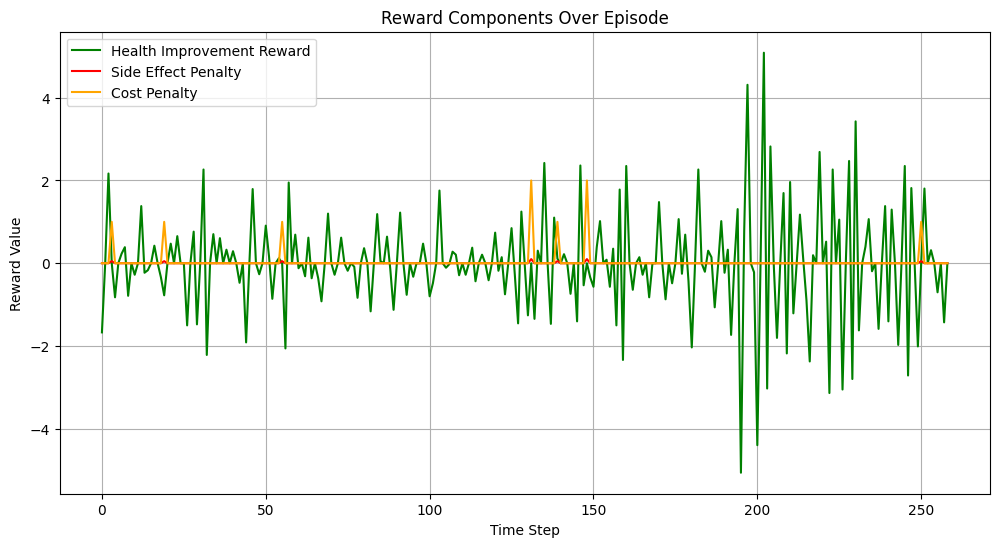

In [ ]:
import matplotlib.pyplot as plt

# Set the figure size for the plot (width=12 inches, height=6 inches)
plt.figure(figsize=(12,6))

# Plot the health improvement reward over time steps in green
plt.plot(reward_health, label='Health Improvement Reward', color='green')

# Plot the side effect penalty over time steps in red
plt.plot(reward_side_effect, label='Side Effect Penalty', color='red')

# Plot the cost penalty over time steps in orange
plt.plot(reward_cost, label='Cost Penalty', color='orange')

# Label x-axis as time step (episode progression)
plt.xlabel('Time Step')

# Label y-axis as reward value (can be positive or negative)
plt.ylabel('Reward Value')

# Set the title of the plot
plt.title('Reward Components Over Episode')

# Show legend to differentiate the plotted lines
plt.legend()

# Enable grid for easier reading of values
plt.grid(True)

# Display the plot
plt.show()

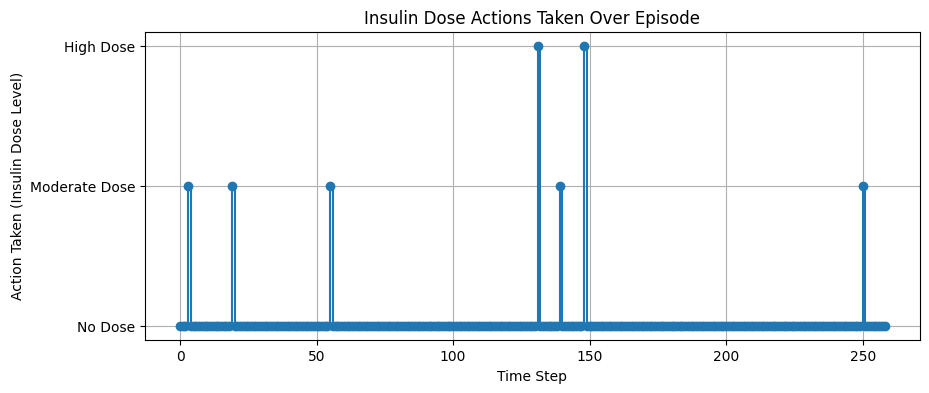

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
plt.figure(figsize=(10,4))  # Set figure size (width=10 inches, height=4 inches)

# Plot actions taken over time steps as step-wise plot with markers at each step
plt.plot(actions_taken, drawstyle='steps-post', marker='o')

plt.xlabel('Time Step')  # Label x-axis
plt.ylabel('Action Taken (Insulin Dose Level)')  # Label y-axis

plt.title('Insulin Dose Actions Taken Over Episode')  # Title of the plot

# Set y-axis ticks and labels to represent insulin dose levels clearly
plt.yticks([0,1,2], ['No Dose', 'Moderate Dose', 'High Dose'])

plt.grid(True)  # Enable grid for readability

plt.show()  # Display the plot

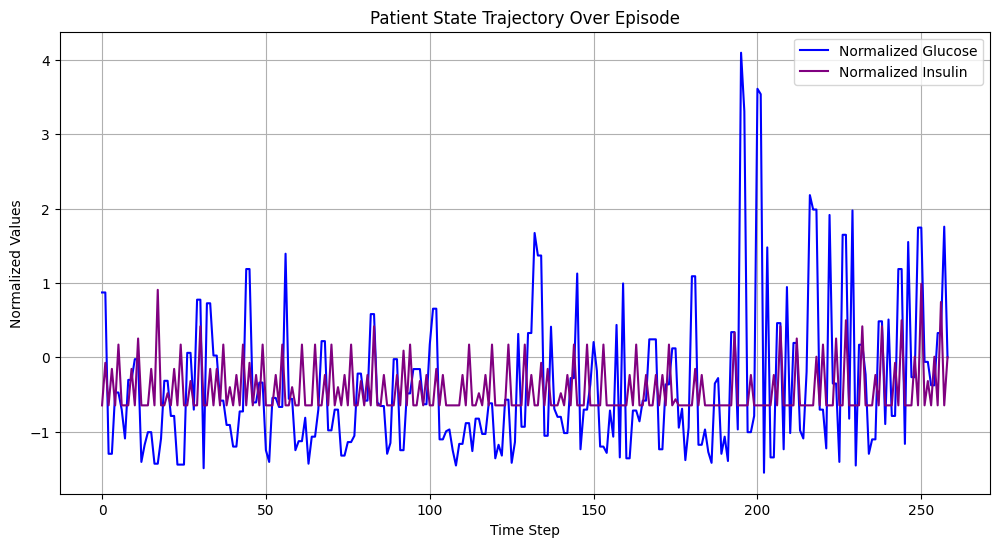

In [ ]:
states = np.array(states)  # Convert list of state arrays to a single NumPy array for easier slicing

plt.figure(figsize=(12,6))  # Set figure size (width=12 inches, height=6 inches)

# Plot normalized glucose values (index 1 in state vector) over time steps in blue
plt.plot(states[:,1], label='Normalized Glucose', color='blue')

# Plot normalized insulin values (index 0 in state vector) over time steps in purple
plt.plot(states[:,0], label='Normalized Insulin', color='purple')

plt.xlabel('Time Step')  # Label x-axis
plt.ylabel('Normalized Values')  # Label y-axis

plt.title('Patient State Trajectory Over Episode')  # Title of the plot

plt.legend()  # Display legend to differentiate lines
plt.grid(True)  # Enable grid for easier reading
plt.show()  # Display the plot

### Rule Based Agent

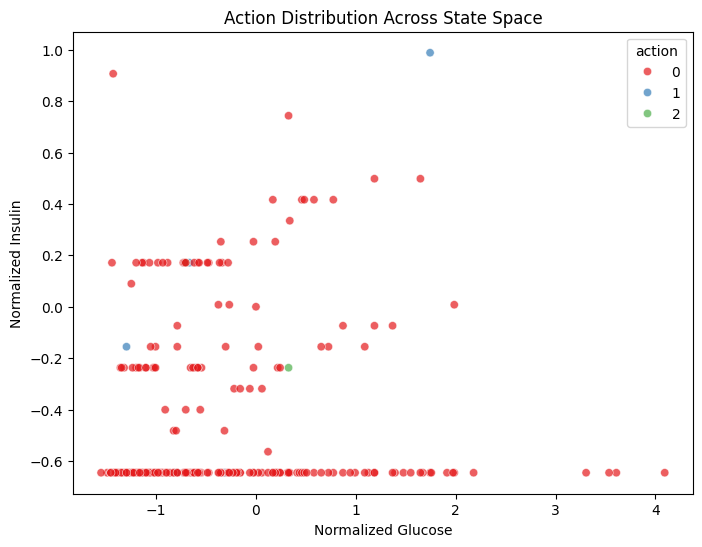

(array([0, 1, 2]), array([252,   5,   2]))
int64


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Convert states list to NumPy array with shape (timesteps, 2)
states = np.array(states)

# Convert actions_taken list to 1D integer NumPy array
actions_array = np.array(actions_taken).flatten().astype(int)

# Create a DataFrame combining normalized glucose, insulin, and corresponding actions
df_actions = pd.DataFrame({
    'glucose_norm': states[:, 1],  # normalized glucose values
    'insulin_norm': states[:, 0],  # normalized insulin values
    'action': actions_array         # discrete action labels
})

plt.figure(figsize=(8, 6))  # Set figure size

# Create scatterplot of insulin vs glucose, colored by the action taken
sns.scatterplot(
    data=df_actions,
    x='glucose_norm',
    y='insulin_norm',
    hue='action',        # Color points by action category
    palette='Set1',      # Color palette for categorical values
    alpha=0.7            # Set transparency for better visualization
)

plt.title('Action Distribution Across State Space')  # Plot title
plt.xlabel('Normalized Glucose')                      # X-axis label
plt.ylabel('Normalized Insulin')                      # Y-axis label

plt.show()  # Display the plot

# Print unique action values and their counts for analysis
print(np.unique(actions_array, return_counts=True))

# Print the dtype of actions_array to verify it is integer
print(actions_array.dtype)

### save PPO Model

In [ ]:
# Instantiate the diabetes environment with the prepared dataset
env = DiabetesEnv(pivot_df)

from stable_baselines3 import PPO

# Load the pre-trained PPO model from the saved zip file, passing the environment for compatibility
model = PPO.load("/content/ppo_diabetes_model.zip", env=env)

# Optional: further train (fine-tune) the model on the current environment for 5,000 time steps
model.learn(total_timesteps=5000)

# Save the fine-tuned model to a new file
model.save("/content/ppo_diabetes_model_finetuned")

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 211      |
|    ep_rew_mean     | -5.52    |
| time/              |          |
|    fps             | 205      |
|    iterations      | 1        |
|    time_elapsed    | 9        |
|    total_timesteps | 2048     |
---------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 248          |
|    ep_rew_mean          | -5.51        |
| time/                   |              |
|    fps                  | 227          |
|    iterations           | 2            |
|    time_elapsed         | 18           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0010774296 |
|    clip_fraction        | 0.0119       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0816      |
|    explained_variance   | 0.286        |
|    learning_rate        | 0.0003       |
|    loss                 | 1.89         |
|    n_updates            | 160          |
|    policy_gradient_loss | -0.00201     |
|    value_loss           | 2.71         |
------------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 218          |
|    ep_rew_mean          | -3.91        |
| time/                   |              |
|    fps                  | 256          |
|    iterations           | 3            |
|    time_elapsed         | 23           |
|    total_timesteps      | 6144         |
| train/                  |              |
|    approx_kl            | 0.0010048875 |
|    clip_fraction        | 0.0106       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0619      |
|    explained_variance   | 0.364        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.689        |
|    n_updates            | 170          |
|    policy_gradient_loss | -0.00227     |
|    value_loss           | 1.93         |
------------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


# Agent Training DQN Model

In [ ]:
from stable_baselines3 import DQN  # Import Deep Q-Network algorithm

# Instantiate the diabetes environment with the prepared dataset
env = DiabetesEnv(pivot_df)

# Create a DQN model using MLP policy to interact with the environment
dqn_model = DQN('MlpPolicy', env, verbose=1)

# Train the DQN model for 30,000 time steps (adjust as needed)
dqn_model.learn(total_timesteps=30000)

# Save the trained DQN model to disk for later use or evaluation
dqn_model.save("dqn_diabetes_model")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 214      |
|    ep_rew_mean      | -186     |
|    exploration_rate | 0.728    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 565      |
|    time_elapsed     | 1        |
|    total_timesteps  | 858      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.533    |
|    n_updates        | 189      |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 349      |
|    ep_rew_mean      | -190     |
|    exploration_rate | 0.117    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 498      |
|    time_elapsed     | 5        |
|    total_timesteps  | 2790     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.218    |
|    n_updates        | 672      |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 331      |
|    ep_rew_mean      | -133     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 12       |
|    fps              | 464      |
|    time_elapsed     | 8        |
|    total_timesteps  | 3975     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.13     |
|    n_updates        | 968      |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 354      |
|    ep_rew_mean      | -105     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 16       |
|    fps              | 471      |
|    time_elapsed     | 12       |
|    total_timesteps  | 5670     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.197    |
|    n_updates        | 1392     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 319      |
|    ep_rew_mean      | -85.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20       |
|    fps              | 471      |
|    time_elapsed     | 13       |
|    total_timesteps  | 6388     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.315    |
|    n_updates        | 1571     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 303      |
|    ep_rew_mean      | -73.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 24       |
|    fps              | 473      |
|    time_elapsed     | 15       |
|    total_timesteps  | 7273     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.25     |
|    n_updates        | 1793     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 299      |
|    ep_rew_mean      | -64.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 28       |
|    fps              | 469      |
|    time_elapsed     | 17       |
|    total_timesteps  | 8385     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.292    |
|    n_updates        | 2071     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 304      |
|    ep_rew_mean      | -58.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 32       |
|    fps              | 458      |
|    time_elapsed     | 21       |
|    total_timesteps  | 9732     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.226    |
|    n_updates        | 2407     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 300      |
|    ep_rew_mean      | -53.4    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 36       |
|    fps              | 460      |
|    time_elapsed     | 23       |
|    total_timesteps  | 10793    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.133    |
|    n_updates        | 2673     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 302      |
|    ep_rew_mean      | -50      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 40       |
|    fps              | 462      |
|    time_elapsed     | 26       |
|    total_timesteps  | 12090    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0554   |
|    n_updates        | 2997     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 294      |
|    ep_rew_mean      | -46.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 44       |
|    fps              | 463      |
|    time_elapsed     | 27       |
|    total_timesteps  | 12954    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.113    |
|    n_updates        | 3213     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 279      |
|    ep_rew_mean      | -43.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 48       |
|    fps              | 463      |
|    time_elapsed     | 28       |
|    total_timesteps  | 13404    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.19     |
|    n_updates        | 3325     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 273      |
|    ep_rew_mean      | -40.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 52       |
|    fps              | 459      |
|    time_elapsed     | 30       |
|    total_timesteps  | 14179    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.152    |
|    n_updates        | 3519     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 277      |
|    ep_rew_mean      | -39.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 56       |
|    fps              | 455      |
|    time_elapsed     | 34       |
|    total_timesteps  | 15496    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.169    |
|    n_updates        | 3848     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 276      |
|    ep_rew_mean      | -37.7    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 60       |
|    fps              | 456      |
|    time_elapsed     | 36       |
|    total_timesteps  | 16567    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0844   |
|    n_updates        | 4116     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 274      |
|    ep_rew_mean      | -36.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 64       |
|    fps              | 457      |
|    time_elapsed     | 38       |
|    total_timesteps  | 17541    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.124    |
|    n_updates        | 4360     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 270      |
|    ep_rew_mean      | -34.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 68       |
|    fps              | 458      |
|    time_elapsed     | 40       |
|    total_timesteps  | 18351    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.142    |
|    n_updates        | 4562     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 268      |
|    ep_rew_mean      | -33.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 72       |
|    fps              | 458      |
|    time_elapsed     | 42       |
|    total_timesteps  | 19289    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.133    |
|    n_updates        | 4797     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 266      |
|    ep_rew_mean      | -32.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 76       |
|    fps              | 452      |
|    time_elapsed     | 44       |
|    total_timesteps  | 20188    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0316   |
|    n_updates        | 5021     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 256      |
|    ep_rew_mean      | -31      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 80       |
|    fps              | 452      |
|    time_elapsed     | 45       |
|    total_timesteps  | 20519    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0195   |
|    n_updates        | 5104     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 251      |
|    ep_rew_mean      | -30      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 84       |
|    fps              | 452      |
|    time_elapsed     | 46       |
|    total_timesteps  | 21096    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0226   |
|    n_updates        | 5248     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 255      |
|    ep_rew_mean      | -29.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 88       |
|    fps              | 454      |
|    time_elapsed     | 49       |
|    total_timesteps  | 22405    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0253   |
|    n_updates        | 5576     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 252      |
|    ep_rew_mean      | -28.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 92       |
|    fps              | 454      |
|    time_elapsed     | 50       |
|    total_timesteps  | 23179    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0163   |
|    n_updates        | 5769     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 248      |
|    ep_rew_mean      | -27.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 96       |
|    fps              | 454      |
|    time_elapsed     | 52       |
|    total_timesteps  | 23812    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0399   |
|    n_updates        | 5927     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 246      |
|    ep_rew_mean      | -26.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 100      |
|    fps              | 455      |
|    time_elapsed     | 53       |
|    total_timesteps  | 24551    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0371   |
|    n_updates        | 6112     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 251      |
|    ep_rew_mean      | -19.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 104      |
|    fps              | 450      |
|    time_elapsed     | 57       |
|    total_timesteps  | 25967    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0521   |
|    n_updates        | 6466     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 241      |
|    ep_rew_mean      | -12.8    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 108      |
|    fps              | 450      |
|    time_elapsed     | 59       |
|    total_timesteps  | 26850    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0399   |
|    n_updates        | 6687     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 238      |
|    ep_rew_mean      | -12.5    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 112      |
|    fps              | 451      |
|    time_elapsed     | 61       |
|    total_timesteps  | 27760    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0476   |
|    n_updates        | 6914     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 234      |
|    ep_rew_mean      | -12.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 116      |
|    fps              | 452      |
|    time_elapsed     | 64       |
|    total_timesteps  | 29053    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.118    |
|    n_updates        | 7238     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 233      |
|    ep_rew_mean      | -12.3    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 120      |
|    fps              | 452      |
|    time_elapsed     | 65       |
|    total_timesteps  | 29647    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0386   |
|    n_updates        | 7386     |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [ ]:
class RuleBasedAgent:
    def __init__(self):
        pass  # No initialization needed for this simple agent

    def act(self, state):
        glucose = state[1]  # Extract normalized glucose value from state

        # Simple heuristic policy:
        if glucose < -0.5:
            return 0  # No insulin dose if glucose is low
        elif glucose < 0.5:
            return 1  # Moderate dose if glucose is moderately high
        else:
            return 2  # High dose if glucose is high

# Example evaluation loop using the rule-based agent
agent = RuleBasedAgent()
obs, _ = env.reset()  # Reset environment to start
done = False
rewards = []

while not done:
    action = agent.act(obs)  # Get action based on current observation/state
    obs, reward, done, _, _ = env.step(action)  # Take action in environment
    rewards.append(reward)  # Record received reward

# Print total reward accumulated over episode
print(f"Rule-Based Total Reward: {sum(rewards)}")

Rule-Based Total Reward: -35.41315799951553


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


# Evaluation

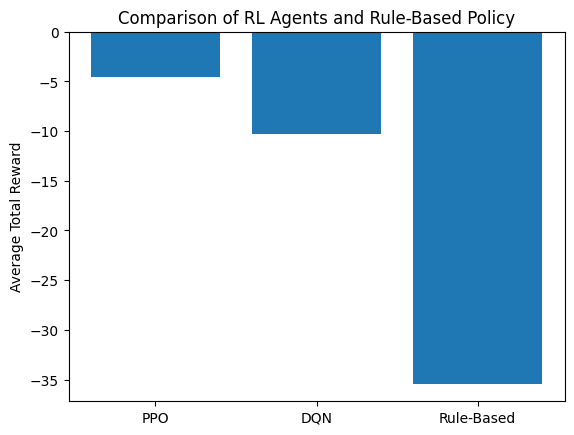

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
def evaluate_model(model, env, episodes=5):
    all_rewards = []  # Store total rewards per episode
    for ep in range(episodes):
        obs, _ = env.reset()  # Reset environment at the start of each episode
        done = False
        ep_rewards = []  # Rewards collected during the current episode
        while not done:
            # Predict action using the RL model's policy based on current observation
            action, _ = model.predict(obs)
            # Take action in environment, receive next state and reward
            obs, reward, done, _, _ = env.step(action)
            ep_rewards.append(reward)  # Record reward for this step
        all_rewards.append(sum(ep_rewards))  # Sum rewards at episode end
    return all_rewards  # Return list of total rewards per episode

# Evaluate PPO model over 5 episodes
ppo_rewards = evaluate_model(model, env)

# Evaluate DQN model over 5 episodes
dqn_rewards = evaluate_model(dqn_model, env)

# Rule-based evaluation results were collected previously in `rewards`

import matplotlib.pyplot as plt

# Plot average total rewards of each agent type for comparison
plt.bar(
    ['PPO', 'DQN', 'Rule-Based'],                      # Agent labels
    [np.mean(ppo_rewards), np.mean(dqn_rewards), sum(rewards)]  # Average rewards per agent
)
plt.ylabel('Average Total Reward')  # Y-axis label
plt.title('Comparison of RL Agents and Rule-Based Policy')  # Plot title
plt.show()  # Display bar chart

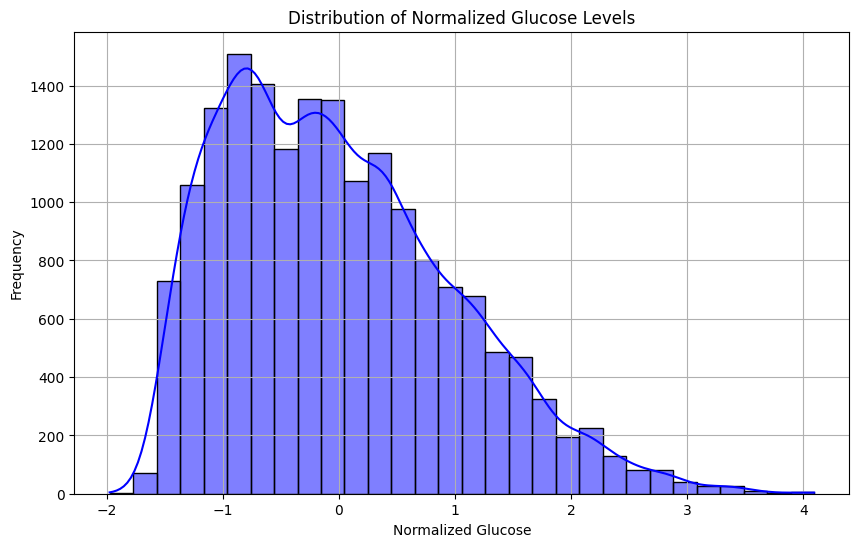

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))  # Set figure size (width=10 inches, height=6 inches)

# Plot histogram with KDE (kernel density estimate) of normalized glucose values
sns.histplot(
    pivot_df['glucose_norm'],  # Data to plot
    bins=30,                   # Number of histogram bins
    kde=True,                  # Overlay KDE curve
    color='blue'               # Bar color
)

plt.title('Distribution of Normalized Glucose Levels')  # Title of the plot
plt.xlabel('Normalized Glucose')                        # X-axis label
plt.ylabel('Frequency')                                 # Y-axis label

plt.grid(True)  # Enable grid for better readability

plt.show()  # Display the plot

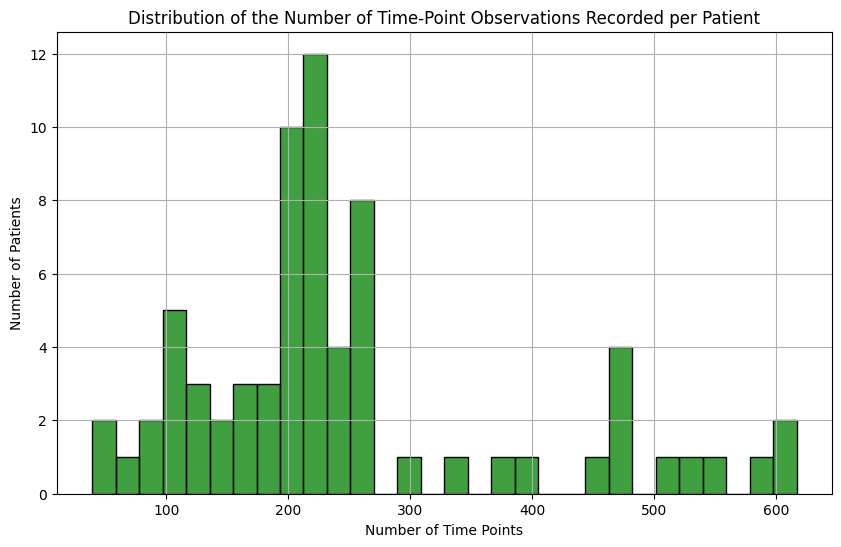

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
# Count the number of observations (rows) per patient_id
obs_counts = pivot_df.groupby('patient_id').size()

plt.figure(figsize=(10,6))  # Set figure size (width=10 inches, height=6 inches)

# Plot histogram of the number of observations per patient
sns.histplot(
    obs_counts,  # Data: counts of time points per patient
    bins=30,     # Number of bins for the histogram
    kde=False,   # Do not show KDE curve
    color='green'  # Color of the bars
)

plt.title('Distribution of the Number of Time-Point Observations Recorded per Patient')  # Plot title
plt.xlabel('Number of Time Points')  # X-axis label
plt.ylabel('Number of Patients')     # Y-axis label

plt.grid(True)  # Enable grid lines for better readability

plt.show()  # Show the plot

# Running the 100-Episode Evaluation

--- Starting Robust Evaluation of All Agents ---

Evaluating PPO Agent for 100 episodes...
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

PPO evaluation complete.

Evaluating DQN Agent for 100 episodes...
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

DQN evaluation complete.

Evaluating Rule-Based Agent for 100 episodes...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

Rule-Based Agent evaluation complete.

--- ROBUST EVALUATION RESULTS ---
Number of episodes per agent: 100

PPO Agent:        Mean Reward = -0.03 +/- 1.43
DQN Agent:        Mean Reward = -0.22 +/- 1.43
Rule-Based Agent: Mean Reward = -231.30 +/- 132.60

Generating comparative performance plot...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


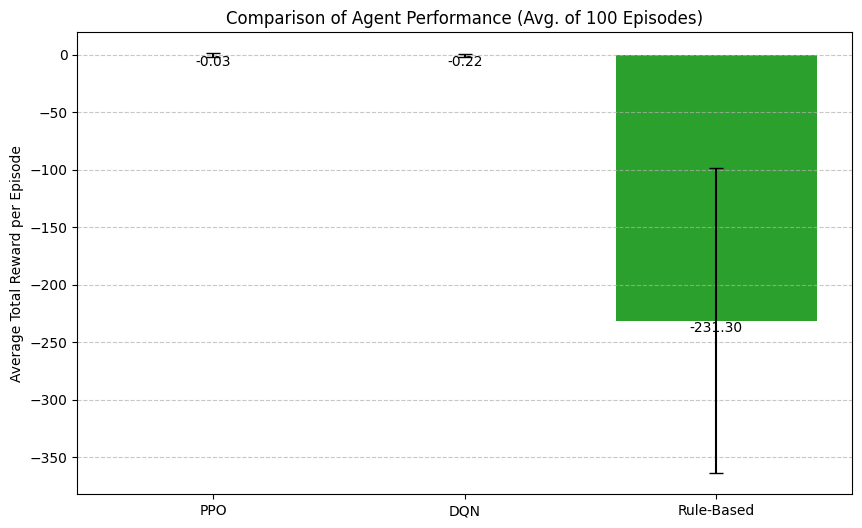

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import PPO, DQN
import pandas as pd # Ensure pandas is imported if not already

# --- PRE-REQUISITES ---
# This cell assumes the following have been defined and are available in the notebook's memory:
# 1. The 'pivot_df' DataFrame containing the preprocessed patient data.
# 2. The 'DiabetesEnv' class definition.
# 3. The 'RuleBasedAgent' class definition.
# 4. Your trained models ("ppo_diabetes_model" and "dqn_diabetes_model") are saved in the environment.

# --- SETUP ---
print("--- Starting Robust Evaluation of All Agents ---")
NUM_EVAL_EPISODES = 100
env = DiabetesEnv(pivot_df)

# --- 1. PPO Agent Evaluation Loop (100 Episodes) ---
print(f"\nEvaluating PPO Agent for {NUM_EVAL_EPISODES} episodes...")
ppo_model = PPO.load("ppo_diabetes_model", env=env)
ppo_episode_rewards = []

for i in range(NUM_EVAL_EPISODES):
    obs, _ = env.reset()
    done = False
    total_episode_reward = 0
    while not done:
        # For evaluation, we use deterministic=True to get the model's best-known action
        action, _ = ppo_model.predict(obs, deterministic=True)
        obs, reward, done, _, _ = env.step(action)
        total_episode_reward += reward

    ppo_episode_rewards.append(total_episode_reward)
    # Optional: print progress for each episode
    # print(f"PPO Episode {i+1}/{NUM_EVAL_EPISODES} - Total Reward: {total_episode_reward:.2f}")

print("PPO evaluation complete.")

# --- 2. DQN Agent Evaluation Loop (100 Episodes) ---
print(f"\nEvaluating DQN Agent for {NUM_EVAL_EPISODES} episodes...")
dqn_model = DQN.load("dqn_diabetes_model", env=env)
dqn_episode_rewards = []

for i in range(NUM_EVAL_EPISODES):
    obs, _ = env.reset()
    done = False
    total_episode_reward = 0
    while not done:
        action, _ = dqn_model.predict(obs, deterministic=True)
        obs, reward, done, _, _ = env.step(action)
        total_episode_reward += reward

    dqn_episode_rewards.append(total_episode_reward)
    # Optional: print progress for each episode
    # print(f"DQN Episode {i+1}/{NUM_EVAL_EPISODES} - Total Reward: {total_episode_reward:.2f}")

print("DQN evaluation complete.")

# --- 3. Rule-Based Agent Evaluation Loop (100 Episodes) ---
print(f"\nEvaluating Rule-Based Agent for {NUM_EVAL_EPISODES} episodes...")
rule_based_agent = RuleBasedAgent()
rule_based_episode_rewards = []

for i in range(NUM_EVAL_EPISODES):
    obs, _ = env.reset()
    done = False
    total_episode_reward = 0
    while not done:
        action = rule_based_agent.act(obs)
        obs, reward, done, _, _ = env.step(action)
        total_episode_reward += reward

    rule_based_episode_rewards.append(total_episode_reward)
    # Optional: print progress for each episode
    # print(f"Rule-Based Episode {i+1}/{NUM_EVAL_EPISODES} - Total Reward: {total_episode_reward:.2f}")

print("Rule-Based Agent evaluation complete.")


# --- 4. Calculate and Print Summary Statistics ---
ppo_mean_reward = np.mean(ppo_episode_rewards)
ppo_std_reward = np.std(ppo_episode_rewards)

dqn_mean_reward = np.mean(dqn_episode_rewards)
dqn_std_reward = np.std(dqn_episode_rewards)

rule_based_mean_reward = np.mean(rule_based_episode_rewards)
rule_based_std_reward = np.std(rule_based_episode_rewards)

print("\n--- ROBUST EVALUATION RESULTS ---")
print(f"Number of episodes per agent: {NUM_EVAL_EPISODES}\n")
print(f"PPO Agent:        Mean Reward = {ppo_mean_reward:.2f} +/- {ppo_std_reward:.2f}")
print(f"DQN Agent:        Mean Reward = {dqn_mean_reward:.2f} +/- {dqn_std_reward:.2f}")
print(f"Rule-Based Agent: Mean Reward = {rule_based_mean_reward:.2f} +/- {rule_based_std_reward:.2f}")

# --- 5. Generate Comparative Bar Chart ---
print("\nGenerating comparative performance plot...")
agent_names = ['PPO', 'DQN', 'Rule-Based']
mean_rewards = [ppo_mean_reward, dqn_mean_reward, rule_based_mean_reward]
std_rewards = [ppo_std_reward, dqn_std_reward, rule_based_std_reward]

plt.figure(figsize=(10, 6))
bars = plt.bar(
    agent_names,
    mean_rewards,
    yerr=std_rewards,
    capsize=5,
    color=['#1f77b4', '#ff7f0e', '#2ca02c']
)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2f}', va='bottom' if yval >= 0 else 'top', ha='center')

plt.ylabel('Average Total Reward per Episode')
plt.title(f'Comparison of Agent Performance (Avg. of {NUM_EVAL_EPISODES} Episodes)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**META-LEARNING / FINE-TUNING DEMONSTRATION**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
import pandas as pd
import io

# --- Helper function for robust evaluation ---
def evaluate_rl_agent(model, env, num_episodes=20): # Increased episodes for stability
    """Evaluates a Stable Baselines3 RL agent over a specified number of episodes."""
    episode_rewards = []
    for _ in range(num_episodes):
        obs, _ = env.reset()
        done = False
        total_episode_reward = 0
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, _, _ = env.step(action)
            total_episode_reward += reward
        episode_rewards.append(total_episode_reward)
    return episode_rewards

# --- META-LEARNING / FINE-TUNING DEMONSTRATION ---
print("\n--- Starting Patient-Specific Fine-Tuning Evaluation ---")

# 1. Split data
all_patient_ids = pivot_df['patient_id'].unique()
train_patients = all_patient_ids[:-5]
finetune_patients = all_patient_ids[-5:]

train_df = pivot_df[pivot_df['patient_id'].isin(train_patients)]

# 2. Train a base PPO model on the general population
print("Training a base model on the general patient population...")
train_env = DiabetesEnv(train_df)
base_model = PPO("MlpPolicy", train_env, verbose=0, seed=42, learning_rate=3e-4) # Explicitly set LR
base_model.learn(total_timesteps=30000)
print("Base model training complete.")

# 3. Save the base model to an in-memory buffer for easy reloading
buffer = io.BytesIO()
base_model.save(buffer)
print("Base model saved to in-memory buffer.")

# 4. Evaluate base model vs. fine-tuned model on each new patient
base_model_rewards_all = []
finetuned_model_rewards_all = []

for patient_id in finetune_patients:
    print(f"\nEvaluating on new patient: {patient_id.split('/')[-1]}")
    patient_df = pivot_df[pivot_df['patient_id'] == patient_id]
    patient_env = DiabetesEnv(patient_df)

    # A) Zero-shot performance of the base model
    buffer.seek(0)
    zero_shot_model = PPO.load(buffer, env=patient_env)
    base_rewards = evaluate_rl_agent(zero_shot_model, patient_env)
    base_model_rewards_all.extend(base_rewards)
    print(f"  Base Model (Zero-Shot) Avg Reward: {np.mean(base_rewards):.2f}")

    # B) Fine-tune a copy of the model on this patient's data
    buffer.seek(0)
    finetune_model = PPO.load(buffer, env=patient_env)
    # --- IMPROVEMENT: Set a lower learning rate for fine-tuning ---
    finetune_model.learning_rate = 5e-5 # Lower LR is crucial for stable fine-tuning
    print("  Fine-tuning model on patient data for 500 steps...")
    finetune_model.learn(total_timesteps=500)

    # Evaluate the fine-tuned model
    finetuned_rewards = evaluate_rl_agent(finetune_model, patient_env)
    finetuned_model_rewards_all.extend(finetuned_rewards)
    print(f"  Fine-Tuned Model Avg Reward: {np.mean(finetuned_rewards):.2f}")

# 5. Final comparison
mean_base = np.mean(base_model_rewards_all)
mean_finetuned = np.mean(finetuned_model_rewards_all)

# Handle negative rewards correctly for percentage calculation
if mean_base == 0:
    improvement = float('inf') if mean_finetuned > 0 else 0
else:
    improvement = ((mean_finetuned - mean_base) / abs(mean_base)) * 100

print("\n--- Meta-Learning / Fine-Tuning Summary ---")
print(f"Average reward of base model on new patients: {mean_base:.2f}")
print(f"Average reward of fine-tuned model on new patients: {mean_finetuned:.2f}")
print(f"Percentage improvement from fine-tuning: {improvement:.2f}%")


--- Starting Patient-Specific Fine-Tuning Evaluation ---
Training a base model on the general patient population...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

Base model training complete.
Base model saved to in-memory buffer.

Evaluating on new patient: data-66


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

  Base Model (Zero-Shot) Avg Reward: -0.71
  Fine-tuning model on patient data for 500 steps...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

  Fine-Tuned Model Avg Reward: -0.71

Evaluating on new patient: data-67


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

  Base Model (Zero-Shot) Avg Reward: -0.34
  Fine-tuning model on patient data for 500 steps...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

  Fine-Tuned Model Avg Reward: -0.34

Evaluating on new patient: data-68


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

  Base Model (Zero-Shot) Avg Reward: 0.19
  Fine-tuning model on patient data for 500 steps...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

  Fine-Tuned Model Avg Reward: 0.19

Evaluating on new patient: data-69


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

  Base Model (Zero-Shot) Avg Reward: 0.70
  Fine-tuning model on patient data for 500 steps...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

  Fine-Tuned Model Avg Reward: 0.70

Evaluating on new patient: data-70


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

  Base Model (Zero-Shot) Avg Reward: 1.15
  Fine-tuning model on patient data for 500 steps...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

  Fine-Tuned Model Avg Reward: 1.15

--- Meta-Learning / Fine-Tuning Summary ---
Average reward of base model on new patients: 0.20
Average reward of fine-tuned model on new patients: 0.20
Percentage improvement from fine-tuning: 0.00%


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
